기본설정

In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import pickle
import datetime

import tensorflow as tf

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

matplotlib.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

# 데이터 불러오기

In [0]:
def get_dataframe(data_name_with_route):
    ## load news data
    with open(data_name_with_route, 'rb') as file:
        data_list = []
        while True:
            try:
                data = pickle.load(file)
            except EOFError:
                break
            data_list.append(data)
    ## construct lists for dataframe
    title = []
    content = []
    date = []
    for news in data_list[0]['return_object']['documents']: 
        title.append(news['title'])
        content.append(news['content'])
        date.append(news['published_at'][:10]) #### 시간 조정이 필요하면 바꾸기
    ## make lists as dataframe
    news_data = pd.DataFrame([])
    news_data['date'] = date
    news_data['title'] = title
    news_data['content'] = content
    return news_data

In [0]:
data = get_dataframe('rawdata_손흥민.pickle')
display(data.head())

,date,title,content
0,2019-04-17,포체티노 감독 “SON만 믿는다”,내일 챔스리그 8강 2차전\n\n맨시티 잡으면 4강 확정\n\n\n\n“손을 믿는다...
1,2019-04-17,"CNN, ""손흥민 팔로워 198만, 아시아 최고 스포츠 스타""",미국 CNN이 아시아 최고 스포츠스타 손흥민(27·토트넘)을 집중조명했다. \n \...
2,2019-04-17,"'크루이프 후계자들' 아약스 버전 4.0, 호날두 울렸다",‘크루이프 후계자들’ 아약스가 크리스티아누 호날두(유벤투스)를 울렸다. \n \n ...
3,2019-04-17,"‘아약스, 유벤투스 꺾고 22년 만에 4강’ 메시 멀티골…바르셀로나 4강 합류",네덜란드 아약스가 크리스티아누 호날두가 속해 있는 이탈리아 유벤투스를 꺾고 22년 ...
4,2019-04-17,"친구는 오리가족, 휴식은 체력단련…오늘도 산골서 ‘나와의 싸움’",지난 15일 경기 광주의 한 경찰기숙학원. 오전 7시 30분이 되자 걸그룹 트와이스...


# 기사 시간 순 그래프 그리기

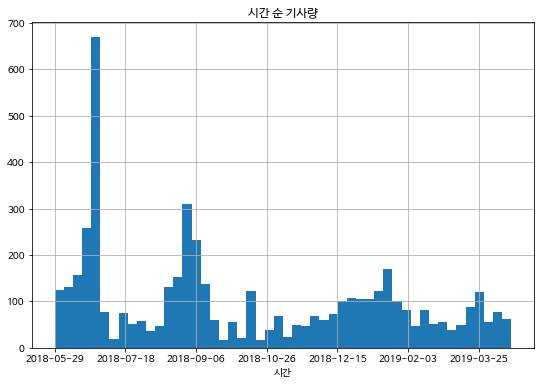

In [0]:
data['date_tmp'] = data['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d').toordinal())

data['date_tmp'].hist(bins=50, figsize=(9,6))
plt.title("시간 순 기사량")
plt.xlabel('시간')
list_date_tmp = []
list_date = []
for i in range(min(data['date_tmp']), max(data['date_tmp']), 50):
    list_date_tmp.append(i)
    time = str(datetime.datetime.fromordinal(i))[:10]
    list_date.append(time)
list_date

plt.xticks(list_date_tmp, list_date)
plt.show()

# 데이터 전처리

In [0]:
data.drop(['date_tmp'], axis=1, inplace=True)
data.head()

,date,title,content
0,2019-04-17,포체티노 감독 “SON만 믿는다”,내일 챔스리그 8강 2차전\n\n맨시티 잡으면 4강 확정\n\n\n\n“손을 믿는다...
1,2019-04-17,"CNN, ""손흥민 팔로워 198만, 아시아 최고 스포츠 스타""",미국 CNN이 아시아 최고 스포츠스타 손흥민(27·토트넘)을 집중조명했다. \n \...
2,2019-04-17,"'크루이프 후계자들' 아약스 버전 4.0, 호날두 울렸다",‘크루이프 후계자들’ 아약스가 크리스티아누 호날두(유벤투스)를 울렸다. \n \n ...
3,2019-04-17,"‘아약스, 유벤투스 꺾고 22년 만에 4강’ 메시 멀티골…바르셀로나 4강 합류",네덜란드 아약스가 크리스티아누 호날두가 속해 있는 이탈리아 유벤투스를 꺾고 22년 ...
4,2019-04-17,"친구는 오리가족, 휴식은 체력단련…오늘도 산골서 ‘나와의 싸움’",지난 15일 경기 광주의 한 경찰기숙학원. 오전 7시 30분이 되자 걸그룹 트와이스...


## 1. 토큰화

In [0]:
text = data['content'][0]

import re

content_text = re.sub(r'[\n()“”]', ' ', text)
content_text

'내일 챔스리그 8강 2차전  맨시티 잡으면 4강 확정     손을 믿는다.     마우리시오 포체티노 사진  토트넘 홋스퍼 감독이 유럽축구연맹 UEFA 챔피언스리그 8강 2차전을 앞둔 기자회견에서 손흥민을 극찬했다. 포체티노 감독은 2차전을 하루 앞둔 17일 오전 한국시간  영국 맨체스터의 에티하드 스타디움에서 열린 기자회견에서  올 시즌 손흥민은 환상적 이라면서  지난해 11월 이후 손흥민 때문에 행복하다 고 밝혔다.     포체티노 감독은  손흥민은 2018 러시아월드컵, 2018 자카르타-팔렘방아시안게임, 그리고 올해 아시아축구연맹 AFC  아시안컵까지 강행군을 소화했다 며  손흥민은 개인적으로 힘든 시간을 보냈지만, 토트넘에 번번이 기쁨을 안겨주고 있다 고 덧붙였다.    토트넘은 지난 10일 영국 런던의 토트넘 홋스퍼 스타디움에서 열린 맨체스터시티와의 챔피언스리그 8강 1차전 홈경기에서 후반 33분 손흥민의 결승골에 힘입어 1-0으로 승리했다. 그런데 후반 10분 스트라이커 해리 케인이 발목을 다쳐 그라운드를 빠져나갔고, 공격형 미드필더 델레 알리 역시 후반 42분 손목 통증을 호소하며 교체됐다.    케인과 알리의 부상으로 손흥민의 어깨는 더욱 무거워졌다. 그리고 포체티노 감독은 손흥민에게 희망을 걸고 있다. 포체티노 감독은 챔피언스리그 8강 2차전에 대비, 지난 13일 열린 잉글랜드 프리미어리그 허더즈필드전에서 손흥민을 선발에서 제외했고 후반 42분 손흥민을 투입했다. 그리고 손흥민은 출장 시간이 턱없이 부족했지만, 팀의 4번째 골을 돕는 어시스트를 올렸다. 3경기 연속 공격포인트. 포체티노 감독은  손흥민은 케인의 공백을 충분히 메울 수 있다 며  손흥민은 노력을 멈추지 않고, 특히 투지를 불태우고 있다 고 강조했다.      김성훈 기자 powerkimsh'

### 1. 단어 토큰화 후보 Hannanum

In [0]:
from konlpy.tag import Hannanum
hannanum = Hannanum()
print(hannanum.morphs(content_text))

['내', '이', 'ㄹ', '챔스리그', '8강', '2차', '전', '맨시티', '잡', '으면', '4강', '확정', '손', '을', '믿', '는다', '.', '마우리시오', '포체티노', '사', '아', '지', 'ㄴ', '토트넘', '홋스퍼', '감독', '이', '유럽축구연맹', 'UEFA', '챔피언스리그', '8강', '2차', '전', '을', '앞두', 'ㄴ', '기자회견', '에서', '손흥민', '을', '극찬', '하', '었다', '.', '포체티노', '감독', '은', '2차', '전', '을', '하루', '앞두', 'ㄴ', '17일', '오전', '한국시간', '영국', '맨체스터', '의', '에티하드', '스타디움', '에서', '열리', 'ㄴ', '기자회견', '에서', '오', 'ㄹ', '시즌', '손흥민', '은', '환상적', '이', '라면서', '지난해', '11월', '이후', '손흥민', '때문', '에', '행복', '하', '다', '고', '밝히', '었다', '.', '포체티노', '감독', '은', '손흥민은', '2018', '러시아월드컵,', '2018', '자카르타-팔렘방아시안게임,', '그리고', '올해', '아시아축구연맹', 'AFC', '아시안컵', '까지', '강행군', '을', '소화', '하', '었다', '며', '손흥민', '은', '개', '이', 'ㄴ', '적', '으로', '힘들', 'ㄴ', '시간', '을', '보내', '었지만', ',', '토트넘', '에', '번번이', '기쁘', 'ㅁ', '을', '안기', '어', '주', '고', '있', '다', '고', '덧붙이', '었다', '.', '토트넘', '은', '지나', 'ㄴ', '10일', '영국', '런던', '의', '토트넘', '홋스퍼', '스타디움', '에서', '열리', 'ㄴ', '맨체스터시티와', '의', '챔피언스리그', '8강', '1차', '전', '홈경기', '에서', '후반', '33분

### 2. 단어 토큰화 후보 Okt

In [0]:
from konlpy.tag import Okt
okt = Okt()
print(okt.morphs(content_text))

['내일', '챔스리그', '8', '강', '2', '차전', '맨시티', '잡으면', '4', '강', '확정', '손', '을', '믿는다', '.', '마', '우리', '시오', '포체', '티노', '사진', '토트넘', '홋스퍼', '감독', '이', '유럽', '축구', '연맹', 'UEFA', '챔피언스리그', '8', '강', '2', '차전을', '앞둔', '기자회견', '에서', '손흥민', '을', '극찬', '했다', '.', '포체', '티노', '감독', '은', '2', '차전을', '하루', '앞둔', '17일', '오전', '한국', '시간', '영국', '맨체스터', '의', '에티하드', '스타디움', '에서', '열린', '기자회견', '에서', '올', '시즌', '손흥민', '은', '환상', '적', '이라면서', '지난해', '11월', '이후', '손흥민', '때문', '에', '행복하다', '고', '밝혔다', '.', '포체', '티노', '감독', '은', '손흥민', '은', '2018', '러시아월드컵', ',', '2018', '자카르타', '-', '팔렘방', '아시안', '게임', ',', '그리고', '올해', '아시아', '축구', '연맹', 'AFC', '아시안컵', '까지', '강행', '군', '을', '소화', '했다', '며', '손흥민', '은', '개인', '적', '으로', '힘든', '시간', '을', '보냈지만', ',', '토트넘', '에', '번번이', '기쁨', '을', '안겨주고', '있다', '고', '덧붙였다', '.', '토트넘', '은', '지난', '10일', '영국', '런던', '의', '토트넘', '홋스퍼', '스타디움', '에서', '열린', '맨체스터', '시티', '와의', '챔피언스리그', '8', '강', '1', '차전', '홈', '경기', '에서', '후반', '33분', '손흥민', '의', '결승골', '에', '힘', '입어', '1-0

#### 이 경우에 단어 사전 추가가 쉬운 ckonlpy로 하겠다.

In [0]:
from ckonlpy.tag import Twitter
twitter = Twitter()
print(twitter.morphs(content_text))

c:\python\lib\site-packages\konlpy\tag\_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


['내일', '챔스리그', '8', '강', '2', '차전', '맨시티', '잡으면', '4', '강', '확정', '손', '을', '믿는다', '.', '마', '우리', '시오', '포', '체티', '노', '사진', '토트넘', '홋스퍼', '감독', '이', '유럽', '축구', '연맹', 'UEFA', '챔피언스리그', '8', '강', '2', '차전을', '앞둔', '기자회견', '에서', '손흥민', '을', '극찬', '했다', '.', '포', '체티', '노', '감독', '은', '2', '차전을', '하루', '앞둔', '17일', '오전', '한국', '시간', '영국', '맨체스터', '의', '에티하드', '스타디움', '에서', '열린', '기자회견', '에서', '올', '시즌', '손흥민', '은', '환상', '적', '이', '라면', '서', '지난해', '11월', '이후', '손흥민', '때문', '에', '행복', '하다', '고', '밝혔다', '.', '포', '체티', '노', '감독', '은', '손흥민', '은', '2018', '러시아월드컵', ',', '2018', '자카르타', '-', '팔렘방', '아시안', '게', '임', ',', '그리', '고', '올해', '아시아', '축구', '연맹', 'AFC', '아시안컵', '까지', '강', '행군', '을', '소화', '했다', '며', '손흥민', '은', '개', '인적', '으로', '힘든', '시간', '을', '보냈', '지만', ',', '토트넘', '에', '번번이', '기쁨', '을', '안겨주고', '있다', '고', '덧붙였다', '.', '토트넘', '은', '지난', '10일', '영국', '런던', '의', '토트넘', '홋스퍼', '스타디움', '에서', '열린', '맨체스터', '시티', '와의', '챔피언스리그', '8', '강', '1', '차전', '홈', '경기', '에서', '후반', '33분', '손흥

In [0]:
## 사전 계속 추가
add_dict = ['마우리시오', 
            '포체티노', 
            '아시안게임', 
            '그리고',]
twitter.add_dictionary(add_dict, 'Noun')
print(twitter.morphs(content_text))

['내일', '챔스리그', '8', '강', '2', '차전', '맨시티', '잡으면', '4', '강', '확정', '손', '을', '믿는다', '.', '마우리시오', '포체티노', '사진', '토트넘', '홋스퍼', '감독', '이', '유럽', '축구', '연맹', 'UEFA', '챔피언스리그', '8', '강', '2', '차전을', '앞둔', '기자회견', '에서', '손흥민', '을', '극찬', '했다', '.', '포체티노', '감독', '은', '2', '차전을', '하루', '앞둔', '17일', '오전', '한국', '시간', '영국', '맨체스터', '의', '에티하드', '스타디움', '에서', '열린', '기자회견', '에서', '올', '시즌', '손흥민', '은', '환상', '적', '이', '라면', '서', '지난해', '11월', '이후', '손흥민', '때문', '에', '행복', '하다', '고', '밝혔다', '.', '포체티노', '감독', '은', '손흥민', '은', '2018', '러시아월드컵', ',', '2018', '자카르타', '-', '팔렘방', '아시안게임', ',', '그리고', '올해', '아시아', '축구', '연맹', 'AFC', '아시안컵', '까지', '강', '행군', '을', '소화', '했다', '며', '손흥민', '은', '개', '인적', '으로', '힘든', '시간', '을', '보냈', '지만', ',', '토트넘', '에', '번번이', '기쁨', '을', '안겨주고', '있다', '고', '덧붙였다', '.', '토트넘', '은', '지난', '10일', '영국', '런던', '의', '토트넘', '홋스퍼', '스타디움', '에서', '열린', '맨체스터', '시티', '와의', '챔피언스리그', '8', '강', '1', '차전', '홈', '경기', '에서', '후반', '33분', '손흥민', '의', '결승골', '에', '힘', '입어', '1-0', '으로',

In [0]:
##불용어는 나중에 계속 추가!
##text로 정리하기
stop_basic = '''
아
휴
아이구
아이쿠
아이고
어
나
우리
저희
따라
의해
을
를
에
의
가
으로
로
에게
뿐이다
의거하여
근거하여
입각하여
기준으로
예하면
예를 들면
예를 들자면
저
소인
소생
저희
지말고
하지마
하지마라
다른
물론
또한
그리고
비길수 없다
해서는 안된다
뿐만 아니라
만이 아니다
만은 아니다
막론하고
관계없이
그치지 않다
그러나
그런데
하지만
든간에
논하지 않다
따지지 않다
설사
비록
더라도
아니면
만 못하다
하는 편이 낫다
불문하고
향하여
향해서
향하다
쪽으로
틈타
이용하여
타다
오르다
제외하고
이 외에
이 밖에
하여야
비로소
한다면 몰라도
외에도
이곳
여기
부터
기점으로
따라서
할 생각이다
하려고하다
이리하여
그리하여
그렇게 함으로써
하지만
일때
할때
앞에서
중에서
보는데서
으로써
로써
까지
해야한다
일것이다
반드시
할줄알다
할수있다
할수있어
임에 틀림없다
한다면
등
등등
제
겨우
단지
다만
할뿐
딩동
댕그
대해서
대하여
대하면
훨씬
얼마나
얼마만큼
얼마큼
남짓
여
얼마간
약간
다소
좀
조금
다수
몇
얼마
지만
하물며
또한
그러나
그렇지만
하지만
이외에도
대해 말하자면
뿐이다
다음에
반대로
반대로 말하자면
이와 반대로
바꾸어서 말하면
바꾸어서 한다면
만약
그렇지않으면
까악
툭
딱
삐걱거리다
보드득
비걱거리다
꽈당
응당
해야한다
에 가서
각
각각
여러분
각종
각자
제각기
하도록하다
와
과
그러므로
그래서
고로
한 까닭에
하기 때문에
거니와
이지만
대하여
관하여
관한
과연
실로
아니나다를가
생각한대로
진짜로
한적이있다
하곤하였다
하
하하
허허
아하
거바
와
오
왜
어째서
무엇때문에
어찌
하겠는가
무슨
어디
어느곳
더군다나
하물며
더욱이는
어느때
언제
야
이봐
어이
여보시오
흐흐
흥
휴
헉헉
헐떡헐떡
영차
여차
어기여차
끙끙
아야
앗
아야
콸콸
졸졸
좍좍
뚝뚝
주룩주룩
솨
우르르
그래도
또
그리고
바꾸어말하면
바꾸어말하자면
혹은
혹시
답다
및
그에 따르는
때가 되어
즉
지든지
설령
가령
하더라도
할지라도
일지라도
지든지
몇
거의
하마터면
인젠
이젠
된바에야
된이상
만큼	어찌됏든
그위에
게다가
점에서 보아
비추어 보아
고려하면
하게될것이다
일것이다
비교적
좀
보다더
비하면
시키다
하게하다
할만하다
의해서
연이서
이어서
잇따라
뒤따라
뒤이어
결국
의지하여
기대여
통하여
자마자
더욱더
불구하고
얼마든지
마음대로
주저하지 않고
곧
즉시
바로
당장
하자마자
밖에 안된다
하면된다
그래
그렇지
요컨대
다시 말하자면
바꿔 말하면
즉
구체적으로
말하자면
시작하여
시초에
이상
허
헉
허걱
바와같이
해도좋다
해도된다
게다가
더구나
하물며
와르르
팍
퍽
펄렁
동안
이래
하고있었다
이었다
에서
로부터
까지
예하면
했어요
해요
함께
같이
더불어
마저
마저도
양자
모두
습니다
가까스로
하려고하다
즈음하여
다른
다른 방면으로
해봐요
습니까
했어요
말할것도 없고
무릎쓰고
개의치않고
하는것만 못하다
하는것이 낫다
매
매번
들
모
어느것
어느
로써
갖고말하자면
어디
어느쪽
어느것
어느해
어느 년도
라 해도
언젠가
어떤것
어느것
저기
저쪽
저것
그때
그럼
그러면
요만한걸
그래
그때
저것만큼
그저
이르기까지
할 줄 안다
할 힘이 있다
너
너희
당신
어찌
설마
차라리
할지언정
할지라도
할망정
할지언정
구토하다
게우다
토하다
메쓰겁다
옆사람
퉤
쳇
의거하여
근거하여
의해
따라
힘입어
그
다음
버금
두번째로
기타
첫번째로
나머지는
그중에서
견지에서
형식으로 쓰여
입장에서
위해서
단지
의해되다
하도록시키다
뿐만아니라
반대로
전후
전자
앞의것
잠시
잠깐
하면서
그렇지만
다음에
그러한즉
그런즉
남들
아무거나
어찌하든지
같다
비슷하다
예컨대
이럴정도로
어떻게
만약
만일
위에서 서술한바와같이
인 듯하다
하지 않는다면
만약에
무엇
무슨
어느
어떤
아래윗
조차
한데
그럼에도 불구하고
여전히
심지어
까지도
조차도
하지 않도록
않기 위하여
때
시각
무렵
시간
동안
어때
어떠한
하여금
네
예
우선
누구
누가 알겠는가
아무도
줄은모른다
줄은 몰랏다
하는 김에
겸사겸사
하는바
그런 까닭에
한 이유는
그러니
그러니까
때문에
그
너희
그들
너희들
타인
것
것들
너
위하여
공동으로
동시에
하기 위하여
어찌하여
무엇때문에
붕붕
윙윙
나
우리
엉엉
휘익
윙윙
오호
아하
어쨋든
만 못하다
하기보다는
차라리
하는 편이 낫다
흐흐
놀라다
상대적으로 말하자면
마치
아니라면
쉿
그렇지 않으면
그렇지 않다면
안 그러면
아니었다면
하든지
아니면
이라면
좋아
알았어
하는것도
그만이다
어쩔수 없다
하나
일
일반적으로
일단
한켠으로는
오자마자
이렇게되면
이와같다면
전부
한마디
한항목
근거로
하기에
아울러
하지 않도록
않기 위해서
이르기까지
이 되다
로 인하여
까닭으로
이유만으로
이로 인하여
그래서
이 때문에
그러므로
그런 까닭에
알 수 있다
결론을 낼 수 있다
으로 인하여
있다
어떤것
관계가 있다
관련이 있다
연관되다
어떤것들
에 대해
이리하여
그리하여
여부
하기보다는
하느니
하면 할수록
운운
이러이러하다
하구나
하도다
다시말하면
다음으로
에 있다
에 달려 있다
우리
우리들
오히려
하기는한데
어떻게
어떻해
어찌됏어
어때
어째서
본대로
자
이
이쪽
여기
이것
이번
이렇게말하자면
이런
이러한
이와 같은
요만큼
요만한 것
얼마 안 되는 것
이만큼
이 정도의
이렇게 많은 것
이와 같다
이때
이렇구나
것과 같이
끼익
삐걱
따위
와 같은 사람들
부류의 사람들
왜냐하면
중의하나
오직
오로지
에 한하다
하기만 하면
도착하다
까지 미치다
도달하다
정도에 이르다
할 지경이다
결과에 이르다
관해서는
여러분
하고 있다
한 후
혼자
자기
자기집
자신
우에 종합한것과같이
총적으로 보면
총적으로 말하면
총적으로
대로 하다
으로서
참
그만이다
할 따름이다
쿵
탕탕
쾅쾅
둥둥
봐
봐라
아이야
아니
와아
응
아이
참나
년
월
일
령
영
일
이
삼
사
오
육
륙
칠
팔
구
이천육
이천칠
이천팔
이천구
하나
둘
셋
넷
다섯
여섯
일곱
여덟
아홉
령
영
'''
stop_words = stop_basic.split()

In [0]:
tokenized_doc = data['content'].apply(lambda x: re.sub(r'[\n()“”]', ' ', x))
tokenized_doc = tokenized_doc.apply(lambda x: twitter.morphs(x))

In [0]:
tokenized_doc = tokenized_doc.apply(lambda x: [item.lower() for item in x if item not in stop_words])
tokenized_doc.head()

0    [내일, 챔스리그, 8, 강, 2, 차전, 맨시티, 잡으면, 4, 강, 확정, 손,...
1    [미국, cnn, 아시아, 최고, 스포츠스타, 손흥민, 27, ·, 토트넘, 집중,...
2    [‘, 크루이프, 후계, ’, 아약스, 크리스티아누, 호날두, 유벤투스, 울렸다, ...
3    [네덜란드, 아약스, 크리스티아누, 호날두, 속, 해, 있는, 이탈리아, 유벤투스,...
4    [지난, 15일, 경기, 광주, 경찰, 기숙, 학원, ., 오전, 7시, 30분, ...
Name: content, dtype: object

## 2. word2vec

불용어 처리를 위해 word2vec을 사용해본다.

In [0]:
result = list(tokenized_doc)
len(result)

5000

In [0]:
from gensim.models import Word2Vec
model = Word2Vec(sentences=result, size=300, window=5, min_count=5, workers=4, sg=1)

In [0]:
tmp = model.wv.most_similar("손흥민")

In [0]:
tmp

[('찼던', 0.5528720617294312),
 ('83분', 0.548201322555542),
 ('건네', 0.5479810237884521),
 ('훗스퍼', 0.5416690111160278),
 ('홋스퍼', 0.5387936234474182),
 ('몰렸던', 0.5376260876655579),
 ('크리스천', 0.5359899997711182),
 ('찰떡', 0.5346112847328186),
 ('세리모니', 0.5319221019744873),
 ('남달랐다', 0.5295933485031128)]

In [0]:
for i in tmp:
    print(i[0])

성원
들께
감동
보상
분들
아낌없이
터져라
호감
자긍심
한마음


In [0]:
stop_words_add =['찼던',
                '찬이었다',
                '찰떡',
                '째다',
                '83분',
                '돌고래',
                 '건네',
                 '아꼈던',
                 '비웠다',
                 '대며',
                 '아당',
                 '들께',
                 '분들',
                ]
stop_words = stop_words + stop_words_add

## 3. BoW

In [0]:
tokens = []
for news in result:
    for token in news:
        tokens.append(token)        

In [0]:
tokens[:10]

['내일', '챔스리그', '8', '강', '2', '차전', '맨시티', '잡으면', '4', '강']

In [0]:
word2index={}  
bow=[]  
for voca in tokens:  
    if voca not in word2index.keys():  
        word2index[voca]=len(word2index)  
        bow.insert(len(word2index),1)
    else:
        index=word2index.get(voca)
        bow[index]=bow[index]+1

In [0]:
count = []
for i, word in enumerate(bow):
    count.append((i, word))

In [0]:
vocab = list(word2index.keys())
sorted_count = sorted(count, key=lambda x: x[1], reverse=True)
tuple_word2index = tuple(word2index.items())

In [0]:
for i, j in sorted_count[:100]:
    print(tuple_word2index[i], j)

('.', 12) 102668
('은', 30) 40019
(',', 55) 26360
('는', 113) 26203
('했다', 29) 23992
('손흥민', 27) 21123
('한국', 34) 15175
('경기', 82) 14509
('다', 189) 12809
('축구', 20) 11799
('선수', 201) 11636
('고', 51) 11120
('감독', 18) 10314
('도', 224) 10076
('골', 137) 9604
('대표팀', 443) 9444
('‘', 166) 9438
('’', 170) 9159
('해', 234) 8494
('토트넘', 16) 8337
('1', 80) 7973
('2', 4) 7849
('이다', 507) 7773
('·', 163) 7550
('전', 125) 7276
('팀', 135) 7217
('"', 1910) 7132
('조', 1126) 6420
('리그', 1128) 5637
('3', 141) 5021
('월드컵', 239) 5011
('위', 221) 4994
('적', 43) 4830
('며', 66) 4769
('독일', 244) 4756
('말', 513) 4700
('기자', 156) 4592
('못', 415) 4308
('후반', 83) 4214
('면서', 256) 4183
("'", 1915) 4171
('-', 57) 4131
('강', 3) 4079
('아시안게임', 59) 4075
('뒤', 805) 3946
('벤', 3938) 3916
('별', 1127) 3518
('됐다', 110) 3466
('투', 2041) 3433
('4', 8) 3422
('날', 510) 3341
('상대', 1386) 3332
('시즌', 41) 3326
('황의조', 8100) 3323
('공격', 98) 3313
('지난', 75) 3276
('수비', 371) 3223
('득점', 1199) 3175
('16', 578) 3161
('대회', 322) 3144
('있는',

In [0]:
for i, j in sorted_count[:100]:
    print(tuple_word2index[i][0])

.
은
,
는
했다
손흥민
한국
경기
다
축구
선수
고
감독
도
골
대표팀
‘
’
해
토트넘
1
2
이다
·
전
팀
"
조
리그
3
월드컵
위
적
며
독일
말
기자
못
후반
면서
'
-
강
아시안게임
뒤
벤
별
됐다
투
4
날
상대
시즌
황의조
공격
지난
수비
득점
16
대회
있는
출전
멕시코
두
스웨덴
기록
승리
열린
들이
더
팬
게
지
차전
아시안컵
중
에는
찬
2018
전반
히
한다
패
된
이어
8
첫
러시아
명
황희
공격수
a
이승우
슈팅
과의
대
이후
선발
유럽
기성용


### 이슈정리

1. 불용어 처리하는 더 똑똑한 방법이 생각나지 않음... ㅠㅠ
2. 외국선수 이름의 경우 표기법 정해져있지 않음. ex) 홋스퍼, 훗스퍼
3. 외국선수 이름의 경우 성과 이름이 분리됨. ex) 해리 케인 -> '해리', '케인'
4. 외국선수 이름을 성으로 부를 때와 이름으로 부를 때가 있음. ex) 해리가 골을 넣었다. 케인이 골을 넣었다.

불용어의 경우 데이터마다 자세한 처리가 필요한 것 같음